I claimed that `D` is actually the distribution of agents on the steady state over $e\_grid \times a\_grid$ (the product space betwen `e_grid` and `a_grid`). I will prove this claim. Feel free to ignore the text blocks that are in {}, they are just side comments. 


This should work for any model, and I will use the one with sticky wages because it solves really fast:

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import random

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules

def household_guess(a_grid,r,z_grid,gamma,T):
    new_z = np.ones((z_grid.shape[0],1))
    wel = (1 + r) * a_grid[np.newaxis,:] + new_z + T[:,np.newaxis]
    V_prime = (1 + r) * (wel * 0.1) ** (-gamma)
    return V_prime

@het(exogenous = 'Pi',policy = 'a', backward = 'V_prime', backward_init = household_guess)
def household(V_prime_p,a_grid,z_grid,e_grid,r,T,beta,gamma,v,tauc):

    c_prime = (beta *(1+tauc)* V_prime_p) ** (-1/gamma) # c_prime is the new guess for c_t

    new_grid = (1 + tauc) * c_prime + a_grid[np.newaxis,:] - z_grid[:,np.newaxis] - T[:,np.newaxis]
    wel = (1 + r) * a_grid

    c = interpolate.interpolate_y(new_grid,wel,c_prime)

    a = wel + z_grid[:,np.newaxis] + T[:,np.newaxis] - (1 + tauc) * c
    V_prime = (1 + r)/(1+tauc) * c ** (-gamma)

    # checks for violations of the condition of minimal assets required and fixes it
    indexes_asset = np.nonzero(a < a_grid[0]) #first dimension: labor grid, second dimension: asset grid
    if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:
        
        a[indexes_asset] = a_grid[0]
        c[indexes_asset] = (wel[indexes_asset[1]] + z_grid[indexes_asset[0]] 
                            + T[indexes_asset[0]] - a[indexes_asset])/(1+tauc)
        V_prime[indexes_asset] = (1 + r)/(1+tauc) * (c[indexes_asset]) ** (-gamma)
        
    uce = e_grid[:,np.newaxis] * c ** (-gamma)

    return V_prime,a,c,uce

def income(e_grid, w, N, taun):
    z_grid = (1 - taun) * w * N * e_grid
    return z_grid

def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, Pi, a_grid, pi_e

def transfers(pi_e, Div, Transfer, e_grid):
    # hardwired incidence rules are proportional to skill; scale does not matter 
    tax_rule, div_rule = np.ones(e_grid.size), e_grid #np.ones(e_grid.size)
    div = Div / np.sum(pi_e * div_rule) * div_rule
    transfer =  (Transfer) / np.sum(pi_e * tax_rule) * tax_rule 
    T = div + transfer
    return T

hh_inp = household.add_hetinputs([make_grid,transfers,income])

@simple
def firm(Y, w, Z, pi, mu, kappa):
    N = Y / Z
    Div = Y - w * N - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return Div, N

@simple
def monetary(pi, rstar, phi_pi):
    r = (1 + rstar(-1) + phi_pi * pi(-1)) / (1 + pi) - 1
    return r

@simple
def fiscal(r, Transfer, B, C, N, tauc, taun, w):
    govt_res = Transfer + (1 + r) * B(-1) - tauc * C - taun * w * N - B
    return govt_res

@simple
def mkt_clearing(A, C, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    goods_mkt = Y - C - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return asset_mkt, goods_mkt

@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

@simple 
def union_ss(w, N, UCE, kw, v, muw, tauc, taun):
    phi = ((1 - taun) * w * N ** (-v) * UCE) / ((1 + tauc) * muw) # our formula
    wnkpc = kw * (phi * N ** (1 + v) - (1 - taun) * w * N * UCE / ((1 + tauc) * muw))
    return wnkpc, phi

blocks_ss = [hh_inp, firm, monetary, fiscal, mkt_clearing, nkpc_ss, union_ss]

hank_ss = create_model(blocks_ss, name = "One-Asset HANK SS")

calibration = {'gamma': 1.0, 'v': 2.0, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 7,
               'amin': 0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi_pi': 1.5, 'B': 6.0,
               'kw': 0.0025, 'muw': 1.2, 'N': 1.0, 'tauc': 0.1, 'taun': 0.0}

unknowns_ss = {'beta': 0.986, 'Transfer': -0.03}
targets_ss = {'asset_mkt': 0, 'govt_res': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, backward_tol = 1E-22, solver="hybr")

Nothing controversial so far. Lets define some quantites we need, that come from the problem above:

In [2]:
pi_e = ss0.internals['household']['pi_e']
e_grid = ss0.internals['household']['e_grid']
D = ss0.internals['household']['D']
a_grid = ss0.internals['household']['a_grid']
a = ss0.internals['household']['a']
r = ss0['r']

nE = ss0['nE']
nA = ss0['nA']

I will simulate an economy with one million agents. They will start with a tuple $(\text{productivity shock}, \text{assets})$ that follow $D$. Since $D$ is a joint distribution, we need to select the points from the joint distribution (previously, I tried to select a productivity and then a asset quantity in two separate steps, which gives the wrong result):

In [3]:
nP = 1_000_000
D_vec = np.reshape(D,(nE*nA,1))
start_number = random.choices(range(nE*nA),weights = D_vec, k = nP)

Since the `random.choices` expects a vector and not a matrix, there is a small work here: take the matrix `D` and change it to a vector using `reshape`. The `reshape` command glues lines together. The `start_number` just says which position of the vector $D_vec$ (which is $nA \times nE$) was select. Since it glues lines together (and Python is indexed on 0), then a `start_number` of 500 is the first element of the second line of `D` i.e. zero assets with the second shock in productivity; 501 is the second element of the second line of `D` and so on. To recover the position in the two dimension grid, one recovers the productivity shock by taking the integer part of `start_number/nA` and the modulo (rest of the division) of `start_number` with respect to nA.

Example: `start_number` is 654. Take the integer part of the division of nA:

In [4]:
int(654/nA)

1

So it is the second position to in the productivity shock. Lets get the position on the asset grid. The `a % b` operator is $a \mod b$

In [5]:
654 % nA

154

So the position on the asset grid is 154.

{Note that Python zero indexing makes this a bit easier: for indexes starting in one, both operations above will require we sum one. Example: if the number selected is 42. Then, for a grid of size 500, $42 \mod nA$ is 42 and the integer part of 42/500 is 0}

I will populate two vectors with the productivivty shocks and asset holdings of each of our one million agents:

In [6]:
e_shock = np.zeros(nP)

for i in range(nP):
    e_shock[i] = e_grid[int(start_number[i]/nA)]

start_asset = np.zeros(nP)

for i in range(nP):
    start_asset[i] = a_grid[start_number[i] % nA]

Now to the part we disagree: I will use the decision rule for the assets `ss0.internals['household']['a']` to select the amount of assets the agents will hold given their endowment and shock. The function dows this for one agent:

In [7]:
def return_asset(a,e,a_grid,e_grid,decision_rule):
    a_index = np.nonzero(a == a_grid)
    e_index = np.nonzero(e == e_grid)
    return decision_rule[e_index,a_index]

Loop for all agents:

In [8]:
assets_next = np.zeros(nP)

for i in range(nP):

    assets_next[i] = return_asset(start_asset[i],e_shock[i],a_grid,e_grid,a)

What is the distribution of assets now _over the `a_grid`_? Using `digitize`:

In [9]:
pos = np.digitize(assets_next,a_grid)

Small loop to count how many cases for each bin. Note that the bins are indexed starting with 1, against Python 0 indexing system:

In [10]:
hist = np.zeros(nA)

for i in range(nA):
    hist[i] = np.size(np.nonzero(pos == i + 1))

Graphic that shows the (absolute) differences between the marginal distribution of `D` and the empirical distribution:

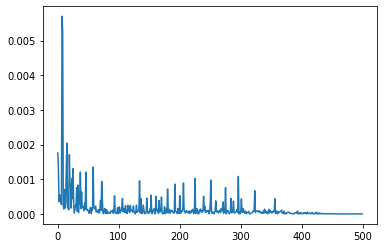

In [11]:
D_marg = np.sum(D,axis=0)
plt.plot(np.abs(D_marg - hist/nP))

I will plot both distributions:

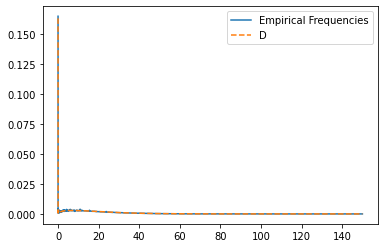

In [13]:
plt.plot(a_grid,hist/nP, label = "Empirical Frequencies")
plt.plot(a_grid,D_marg, label = "D",ls = '--')
plt.legend()
plt.show()